In [34]:
#Here we import all the necessary dependencies
import numpy as np
import matplotlib.pyplot as plt
import time
import amuse.plot as plot
from IPython.display import clear_output
from amuse.lab import units, constants
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import get_orbital_elements_from_binary
from amuse.ext.orbital_elements import get_orbital_elements_from_binaries
from amuse.lab import Particles
from amuse.lab import nbody_system
from amuse.io import write_set_to_file, read_set_from_file
from amuse.units.trigo import arctan

In [3]:
data_loc = "Results/"

In [7]:
logtimes = ['-inf','4.300','4.602','4.778','4.903','4.999','5.0','5.002','5.004','5.006','5.008','5.010','5.305','5.479','5.603','5.699','5.778','6.745','7.022','7.190','7.311','7.405','7.483','7.548','7.605','7.656','7.701','7.742','7.779','7.814','7.846','7.875','7.903','7.929','7.954','7.977']

runs = ['Vanilla_Tack_run7']
for run in runs:
    for i in range(len(logtimes)):
        exec(run+'_'+str(i)+'= read_set_from_file(data_loc+\"'+run+'_time='+logtimes[i]+'.hdf5\", format="hdf5")')

logtimes = [-1e9,4.300,4.602,4.778,4.903,4.999,5.0,5.002,5.004,5.006,5.008,5.010,5.305,5.479,5.603,5.699,5.778,6.745,7.022,7.190,7.311,7.405,7.483,7.548,7.605,7.656,7.701,7.742,7.779,7.814,7.846,7.875,7.903,7.929,7.954,7.977]
times = 10**np.array(logtimes)

In [9]:
sets_7GT = []
for i in range(len(logtimes)):
    exec("sets_7GT.append(Vanilla_Tack_run7_"+str(i)+")")

In [10]:
def separations(p1, p2):
    return (p1.position - p2.position).lengths()

def v_esc(M,r):
    return (2*constants.G*M/r).sqrt()

def v_rel(Sun, particles):
    return (Sun.velocity-particles.velocity).lengths()

def a_orbit(Sun, particles):
    return get_orbital_elements_from_binaries(Sun, particles, constants.G)[2]

def eccentricities(Sun, particles):
    return get_orbital_elements_from_binaries(Sun, particles, constants.G)[3]

def inclinations(particles):
    i = arctan(particles.z/((particles.x**2+particles.y**2).sqrt()))
    return i

In [11]:
Sun = Particles(1)
Sun.name = 'SUN'
Sun.mass = 1 | units.MSun
Sun.position = (0| units.AU, 0| units.AU, 0| units.AU)
Sun.velocity = (0|units.kms, 0| units.kms, 0|units.kms)

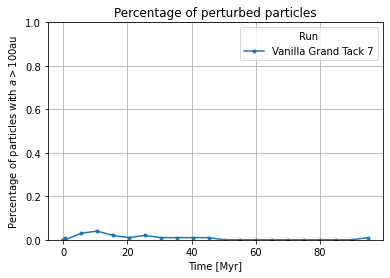

In [16]:
# Determine the percentage of particles with a > 100 AU in each timestep
def percentage_perturbed(sets):
    percentage = []
    n_particles = len(sets[0])
    for particles in sets:
        n_deleted_ps = n_particles - (len(particles))
        percentage.append((sum(a_orbit(Sun, particles[4:]) > (100 | units.AU)) + n_deleted_ps) / (n_particles-4))
    return percentage

perturbed_percentage_7GT = percentage_perturbed(sets_7GT)

plt.plot(times/1e6, perturbed_percentage_7GT, marker='.', label='Vanilla Grand Tack 7')

plt.xlabel("Time [Myr]")
plt.ylabel(r"Percentage of particles with $a>100$au")
plt.grid()
plt.ylim(0, 1)
plt.title('Percentage of perturbed particles')
plt.legend(title='Run')
plt.show()

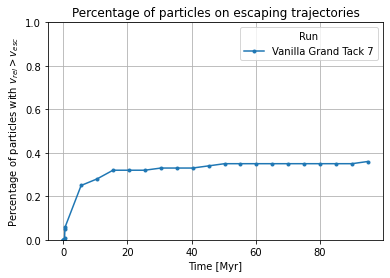

In [17]:
def percentage_vrel_vesc(sets):
    percentages = []
    n_particles = len(sets[0])
    for particles in sets:
        n_deleted_ps = n_particles - (len(particles))
        # mask gives boolean array with True where v_rel > v_esc
        mask = v_rel(Sun,particles[4:]).in_(units.km/units.s) > v_esc(Sun.mass, separations(Sun, particles[4:])).in_(units.km/units.s)
        percentages.append((sum(mask)+n_deleted_ps)/100)
    return percentages

escaping_percentage_7GT = percentage_vrel_vesc(sets_7GT)

plt.plot(times/1e6, escaping_percentage_7GT, marker='.', label='Vanilla Grand Tack 7')

plt.xlabel("Time [Myr]")
plt.ylabel("Percentage of particles with $v_{rel}>v_{esc}$")
plt.grid()
plt.ylim(0, 1)
plt.title('Percentage of particles on escaping trajectories')
plt.legend(title='Run')
plt.show()

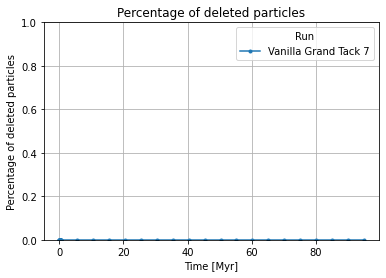

In [19]:
def percentage_deleted(sets):
    n_particles = len(sets[0])
    n_deleted = []
    for particles in sets:
        n_deleted.append(n_particles - len(particles))
    percentage = np.array(n_deleted) / n_particles
    return percentage

deleted_percentage_7GT = percentage_deleted(sets_7GT)

plt.plot(times/1e6, deleted_percentage_7GT, marker='.', label='Vanilla Grand Tack 7')

plt.xlabel("Time [Myr]")
plt.ylabel("Percentage of deleted particles")
plt.grid()
plt.ylim(0, 1)
plt.title('Percentage of deleted particles')
plt.legend(title='Run')
plt.show()

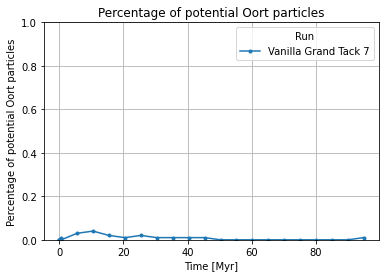

In [20]:
def percentage_pot_Oort(sets):
    # Find particles that have a>100au, v_rel < v_esc, r<250.000au and e<1
    percentages = []
    for i in range(len(logtimes)):
        n_deleted = len(sets[0])-len(sets[i])
        n_oort_objs = len(np.argwhere((a_orbit(Sun, sets[i][4:]) > (100|units.AU)) & (v_rel(Sun, sets[i][4:]).in_(units.km/units.s) < v_esc(Sun.mass, separations(Sun, sets[i][4:])).in_(units.km/units.s)) & (separations(Sun, sets[i][4:])<(250000|units.AU)) & (eccentricities(Sun, sets[i][4:]) < 1)))
        percentages.append((n_oort_objs) / len(sets[0][4:]))
    return percentages

pot_Oort_percentage_7GT = percentage_pot_Oort(sets_7GT)

plt.plot(times/1e6, pot_Oort_percentage_7GT, marker='.', label='Vanilla Grand Tack 7')

plt.xlabel("Time [Myr]")
plt.ylabel("Percentage of potential Oort particles")
plt.grid()
plt.ylim(0, 1)
plt.title('Percentage of potential Oort particles')
plt.legend(title='Run')
plt.show()

In [23]:
def find_pot_Oort_keys(sets): # Takes all particles that were *at some point during the run* classified as pot. Oort cloud object
    keys = []
    for i in range(len(times)):
        oort_objs = np.argwhere((a_orbit(Sun, sets[i]) > (100|units.AU)) & (v_rel(Sun, sets[i]).in_(units.km/units.s) < v_esc(Sun.mass, separations(Sun, sets[i])).in_(units.km/units.s)) & (separations(Sun, sets[i])<(250000|units.AU)) & (eccentricities(Sun, sets[i]) < 1))
        for index in oort_objs:
            if sets[i][index].key not in keys:
                keys.append(sets[i][index].key)
    return keys

def find_pot_Oort_keys2(sets): # Takes all particles that were classified as pot. Oort cloud object *in the last timestep*
    oort_objs = sets[-1][((a_orbit(Sun, sets[-1]) > (100|units.AU)) & (v_rel(Sun, sets[-1]).in_(units.km/units.s) < v_esc(Sun.mass, separations(Sun, sets[-1])).in_(units.km/units.s)) & (separations(Sun, sets[-1])<(250000|units.AU)) & (eccentricities(Sun, sets[-1]) < 1))]
    keys = oort_objs.key
    return keys

In [31]:
def begin_a(sets, keys):
    Oort_a = np.array([])
    for key in keys:
        Oort_a = np.append(Oort_a, a_orbit(Sun, sets[0][sets[0].key==key]).in_(units.AU).number)
    return (Oort_a | units.AU)

def begin_e(sets, keys):
    Oort_e = np.array([])
    for key in keys:
        Oort_e = np.append(Oort_e, eccentricities(Sun, sets[0][sets[0].key==key]))
    return Oort_e

def begin_i(sets, keys):
    Oort_i = np.array([])
    for key in keys:
        Oort_i = np.append(Oort_i, inclinations(sets[0][sets[0].key==key]).in_(units.deg).number)
    return (Oort_i | units.deg)

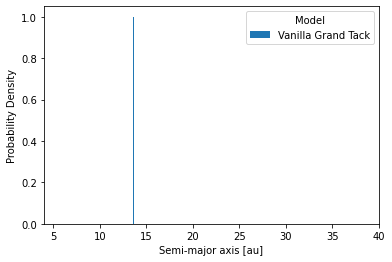

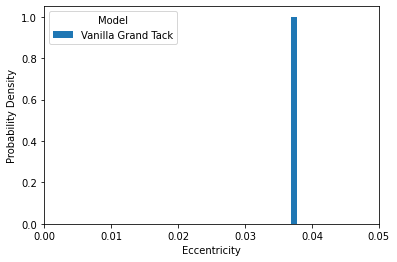

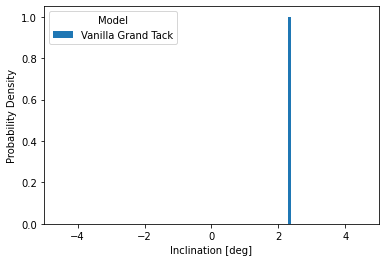

In [45]:
keys_7GT = find_pot_Oort_keys2(sets_7GT)

plot.hist(begin_a(sets_7GT, keys_7GT), label='Vanilla Grand Tack')
plt.xlim(4,40)
plt.xlabel('Semi-major axis [au]')
plt.ylabel('Probability Density')
plt.legend(title='Model')
plt.show()

plot.hist(begin_e(sets_7GT, keys_7GT), width=.001, label='Vanilla Grand Tack')
plt.xlim(0,0.05)
plt.xlabel('Eccentricity')
plt.ylabel('Probability Density')
plt.legend(title='Model')
plt.show()

plot.hist(begin_i(sets_7GT, keys_7GT), label='Vanilla Grand Tack')
plt.xlim(-5,5)
plt.xlabel('Inclination [deg]')
plt.ylabel('Probability Density')
plt.legend(title='Model')
plt.show()